# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt

import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master/hdpy")
# print(sys.path)
import hdpy
import hdpy.ecfp_hd
from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
# import os
# print(os.environ.keys())
# os.environ['PYTHONPATH'] += '/g/g13/jones289/workspace/hd-cuda-master/hdpy'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

In [2]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125")
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124")
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4")
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/0")
# data_p = Path("/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results")

In [3]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [4]:
color_dict = {
#     "smiles-pe.atomwise.0": rocket_color_pal[2],
#     "smiles-pe.bpe.0": rocket_color_pal[4],   
# "selfies.atomwise": green_color_pal[4],
    "ecfp": green_color_pal[6],
#     "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
#     "mlp": blue_color_pal[7],
    "HDC-MLP": green_color_pal[9],
    "Vina": "salmon"
}



marker_dict = {
#     "smiles-pe": "+",
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
#     "smiles-pe.ngram.1": "+",
    "selfies.atomwise": "*",
#     "selfies.selfies-charwise": "*",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
#     "openhd": "*",
    "mlp": "+",
#     "Vina": "+"
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
    ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
    ("ecfp", "HDBind-ECFP"),
    ("rp", "HDBind-ECFP+RP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
#     ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
    "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
    "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
    "ecfp": "HDBind-ECFP",
    "rp": "HDBind-RPFP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina",
    "HDC-MLP": "HDC-MLP"
}


linestyle_dict = {
    "smiles-pe.atomwise.0": "-", 
    "smiles-pe.bpe.0": ":",
    "selfies.None": "-",
    "ecfp": ":",
    "rp": "-.",
    "rf": "-",
    "mlp": ":",
    "Vina": "-"
}

In [5]:
def compute_average_enrichment(pkl_path, model):
    
    enrich_1_list = [] 
    enrich_10_list = []
    
#     import pdb
#     pdb.set_trace()
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
#         for seed in data.keys():

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):

            if isinstance(data[seed]["y_true"], np.ndarray):
                y_true = data[seed]["y_true"]
            else:
                y_true = np.concatenate(data[seed]["y_true"]) 
            y_pred = np.array(data[seed]["y_pred"])

    
            eta = None 
    
            if model in ["rf", "mlp"]:
                eta= data[seed]["model"].predict_proba(data["x_test"])[:,1]
            else:
                eta = np.array(data[seed]["eta"])

            enrich_1 = compute_enrichment_factor(sample_scores=eta, sample_labels=y_true, n_percent=.01)
            enrich_1_list.append(enrich_1)
                
            enrich_10 = compute_enrichment_factor(sample_scores=eta, sample_labels=y_true, n_percent=.1)
            enrich_10_list.append(enrich_10)
            
    
    return np.mean(enrich_1_list), np.std(enrich_1_list), np.mean(enrich_10_list), np.std(enrich_10_list)




def compute_average_train_time(pkl_path):
    print(pkl_path)
    train_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        target = pkl_path.name.split(".")[2]
        split = pkl_path.name.split(".")[1]
        model = pkl_path.name.split(".")[3]

        range_limit = 10
    
        if "openhd" in model:
            range_limit=1
        for seed in range(range_limit):

            train_time  = data[seed]["train_time"]

            if "openhd" in model:
                pass
            
            elif "mlp" in model:
                train_time = train_time / 10 # trained MLP for max 10 epochs...check that it hits that but assume it didn't converge that quickly
            elif "rf" in model:
                train_time = train_time # there's no concept of epoch in a random forest
            else:
                train_time = train_time/10 # this should catch all HD models which were trained for 10 epochs per seed
            
            train_time_list.append(train_time)
            
            
    
    return np.mean(train_time_list)



def compute_average_inference_time(pkl_path):
    
    test_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):

            test_time  = data[seed]["test_time"]

            test_time_list.append(test_time)
            
            
    
    return np.mean(test_time_list)
                    

# LIT-PCBA Results

In [6]:
def aggregate_results(dataset):
    
    
    
    
    model_metric_dict = {"model": [], "enrich-1-mean": [], 
                         "enrich-1-std":[], "enrich-10-mean": [], 
                         "enrich-10-std": [], "train_time":[], "test_time": []}
    

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]

    for model, color in color_dict.items():
                        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        
        
        data_path_list = list(data_p.glob(f"{dataset}*.{model}*pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []

        
        for path in tqdm(data_path_list, total=len(data_path_list)):
            print(path)
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
                
                
            enrich_1_mean, enrich_1_std, enrich_10_mean, enrich_10_std = compute_average_enrichment(path, model=model)
            train_time_mean = compute_average_train_time(path)
            test_time_mean = compute_average_inference_time(path)
            
            
            model_metric_dict["model"].append(model)
            model_metric_dict["enrich-1-mean"].append(enrich_1_mean)
            model_metric_dict["enrich-1-std"].append(enrich_1_std)
            model_metric_dict["enrich-10-mean"].append(enrich_10_mean)
            model_metric_dict["enrich-10-std"].append(enrich_10_std)
            model_metric_dict["train_time"].append(train_time_mean)
            model_metric_dict["test_time"].append(test_time_mean)

    return enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ALDH1.ecfp.atomwise.0.pkl
33.0 1792.0 36284 363 1.840706168831169
275.0 1792.0 36284 3629 1.534344491792308
25.0 1792.0 36284 363 1.3944743703266431
259.0 1792.0 36284 3629 1.4450735395425736
29.0 1792.0 36284 363 1.6175902695789062
258.0 1792.0 36284 3629 1.4394941050269652
42.0 1792.0 36284 363 2.34271694214876
344.0 1792.0 36284 3629 1.919325473369287
56.0 1792.0 36284 363 3.1236225895316805
361.0 1792.0 36284 3629 2.0141758601346296
49.0 1792.0 36284 363 2.7331697658402203
307.0 1792.0 36284 3629 1.7128863962917764
65.0 1792.0 36284 363 3.625633362849272
375.0 1792.0 36284 3629 2.092287943353147
13.0 1792.0 36284 363 0.7251266725698544
147.0 1792.0 36284 3629 0.8201768737944337
47.0 1792.0 36284 363 2.621611816214089
329.0 1792.0 36284 3629 1.835633955635161
12.0 1792.0 36284 363 0.6693476977567886
153.0 1792.0 36284 3629 0.853653480888084
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.

  7%|▋         | 1/15 [00:21<05:00, 21.44s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.GBA.ecfp.atomwise.0.pkl
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
1.0 42.0 74055 741 2.379506458453827
6.0 42.0 74055 7406 1.4284749816750897
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.GBA.ecfp.atomwise.0.pkl


 13%|█▎        | 2/15 [00:53<05:57, 27.49s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ago.ecfp.atomwise.0.pkl
1.0 3.0 1399 14 33.30952380952381
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
0.0 3.0 1399 14 0.0
1.0 3.0 1399 140 3.3309523809523807
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ago.ecfp.atomwise.0.pkl


 20%|██        | 3/15 [00:54<03:04, 15.33s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.VDR.ecfp.atomwise.0.pkl
0.0 221.0 89068 891 0.0
8.0 221.0 89068 8907 0.3619828219911433
0.0 221.0 89068 891 0.0
8.0 221.0 89068 8907 0.3619828219911433
0.0 221.0 89068 891 0.0
8.0 221.0 89068 8907 0.3619828219911433
0.0 221.0 89068 891 0.0
8.0 221.0 89068 8907 0.3619828219911433
0.0 221.0 89068 891 0.0
10.0 221.0 89068 8907 0.4524785274889291
0.0 221.0 89068 891 0.0
10.0 221.0 89068 8907 0.4524785274889291
0.0 221.0 89068 891 0.0
9.0 221.0 89068 8907 0.4072306747400362
0.0 221.0 89068 891 0.0
9.0 221.0 89068 8907 0.4072306747400362
0.0 221.0 89068 891 0.0
9.0 221.0 89068 8907 0.4072306747400362
1.0 221.0 89068 891 0.45232617781637396
11.0 221.0 89068 8907 0.49772638023782195
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.VDR.ecfp.atomwise.0.pkl


 27%|██▋       | 4/15 [01:35<04:41, 25.59s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.PKM2.ecfp.atomwise.0.pkl
1.0 137.0 61518 616 0.7289553512181249
14.0 137.0 61518 6152 1.0218645885736524
1.0 137.0 61518 616 0.7289553512181249
14.0 137.0 61518 6152 1.0218645885736524
1.0 137.0 61518 616 0.7289553512181249
14.0 137.0 61518 6152 1.0218645885736524
1.0 137.0 61518 616 0.7289553512181249
14.0 137.0 61518 6152 1.0218645885736524
1.0 137.0 61518 616 0.7289553512181249
14.0 137.0 61518 6152 1.0218645885736524
2.0 137.0 61518 616 1.4579107024362499
14.0 137.0 61518 6152 1.0218645885736524
2.0 137.0 61518 616 1.4579107024362499
15.0 137.0 61518 6152 1.0948549163289132
2.0 137.0 61518 616 1.4579107024362499
17.0 137.0 61518 6152 1.240835571839435
2.0 137.0 61518 616 1.4579107024362499
15.0 137.0 61518 6152 1.0948549163289132
3.0 137.0 61518 616 2.186866053654375
15.0 137.0 61518 6152 1.0948549163289132
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.PKM2.ecfp.atomwise.0.pkl


 33%|███▎      | 5/15 [02:01<04:17, 25.72s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MAPK1.ecfp.atomwise.0.pkl
0.0 77.0 15735 158 0.0
6.0 77.0 15735 1574 0.7789732503836697
0.0 77.0 15735 158 0.0
6.0 77.0 15735 1574 0.7789732503836697
0.0 77.0 15735 158 0.0
6.0 77.0 15735 1574 0.7789732503836697
0.0 77.0 15735 158 0.0
5.0 77.0 15735 1574 0.6491443753197247
0.0 77.0 15735 158 0.0
6.0 77.0 15735 1574 0.7789732503836697
0.0 77.0 15735 158 0.0
4.0 77.0 15735 1574 0.5193155002557798
4.0 77.0 15735 158 5.173434160775933
14.0 77.0 15735 1574 1.8176042508952293
4.0 77.0 15735 158 5.173434160775933
20.0 77.0 15735 1574 2.5965775012788987
4.0 77.0 15735 158 5.173434160775933
20.0 77.0 15735 1574 2.5965775012788987
1.0 77.0 15735 158 1.2933585401939833
17.0 77.0 15735 1574 2.207090876087064
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MAPK1.ecfp.atomwise.0.pkl


 40%|████      | 6/15 [02:07<02:51, 19.10s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.FEN1.ecfp.atomwise.0.pkl
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
1.0 92.0 88943 890 1.0862603810454323
16.0 92.0 88943 8895 1.7389935723537893
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.FEN1.ecfp.atomwise.0.pkl


 47%|████▋     | 7/15 [02:49<03:32, 26.56s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.PPARG.ecfp.atomwise.0.pkl
0.0 7.0 1310 14 0.0
2.0 7.0 1310 131 2.8571428571428568
2.0 7.0 1310 14 26.734693877551017
2.0 7.0 1310 131 2.8571428571428568
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
2.0 7.0 1310 14 26.734693877551017
4.0 7.0 1310 131 5.7142857142857135
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.PPARG.ecfp.atomwise.0.pkl


 53%|█████▎    | 8/15 [02:50<02:08, 18.36s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MTORC1.ecfp.atomwise.0.pkl
0.0 24.0 8268 83 0.0
1.0 24.0 8268 827 0.41656590084643286
0.0 24.0 8268 83 0.0
1.0 24.0 8268 827 0.41656590084643286
0.0 24.0 8268 83 0.0
1.0 24.0 8268 827 0.41656590084643286
0.0 24.0 8268 83 0.0
1.0 24.0 8268 827 0.41656590084643286
0.0 24.0 8268 83 0.0
1.0 24.0 8268 827 0.41656590084643286
0.0 24.0 8268 83 0.0
4.0 24.0 8268 827 1.6662636033857314
1.0 24.0 8268 83 4.150602409638553
4.0 24.0 8268 827 1.6662636033857314
1.0 24.0 8268 83 4.150602409638553
7.0 24.0 8268 827 2.91596130592503
1.0 24.0 8268 83 4.150602409638553
7.0 24.0 8268 827 2.91596130592503
2.0 24.0 8268 83 8.301204819277107
8.0 24.0 8268 827 3.332527206771463
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MTORC1.ecfp.atomwise.0.pkl


 60%|██████    | 9/15 [02:53<01:22, 13.73s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ant.ecfp.atomwise.0.pkl
4.0 26.0 1263 13 14.946745562130179
6.0 26.0 1263 127 2.2949727437916416
3.0 26.0 1263 13 11.210059171597635
9.0 26.0 1263 127 3.442459115687462
4.0 26.0 1263 13 14.946745562130179
6.0 26.0 1263 127 2.2949727437916416
4.0 26.0 1263 13 14.946745562130179
7.0 26.0 1263 127 2.677468201090248
2.0 26.0 1263 13 7.473372781065089
6.0 26.0 1263 127 2.2949727437916416
2.0 26.0 1263 13 7.473372781065089
7.0 26.0 1263 127 2.677468201090248
2.0 26.0 1263 13 7.473372781065089
6.0 26.0 1263 127 2.2949727437916416
2.0 26.0 1263 13 7.473372781065089
6.0 26.0 1263 127 2.2949727437916416
2.0 26.0 1263 13 7.473372781065089
8.0 26.0 1263 127 3.0599636583888556
2.0 26.0 1263 13 7.473372781065089
7.0 26.0 1263 127 2.677468201090248
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ant.ecfp.atomwise.0.pkl


 67%|██████▋   | 10/15 [02:54<00:48,  9.74s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.OPRK1.ecfp.atomwise.0.pkl
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
0.0 6.0 67460 6746 0.0
0.0 6.0 67460 675 0.0
1.0 6.0 67460 6746 1.6666666666666665
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.OPRK1.ecfp.atomwise.0.pkl


 73%|███████▎  | 11/15 [03:26<01:06, 16.53s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.KAT2A.ecfp.atomwise.0.pkl
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
2.0 49.0 87186 872 4.080977345066467
10.0 49.0 87186 8719 2.0407227003658446
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.KAT2A.ecfp.atomwise.0.pkl


 80%|████████  | 12/15 [04:04<01:09, 23.11s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.IDH1.ecfp.atomwise.0.pkl
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
0.0 10.0 90522 906 0.0
3.0 10.0 90522 9053 2.999734894510107
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.IDH1.ecfp.atomwise.0.pkl


 87%|████████▋ | 13/15 [04:45<00:57, 28.55s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.TP53.ecfp.atomwise.0.pkl
2.0 20.0 1062 11 9.654545454545456
8.0 20.0 1062 107 3.9700934579439258
7.0 20.0 1062 11 33.79090909090909
10.0 20.0 1062 107 4.962616822429907
5.0 20.0 1062 11 24.136363636363637
10.0 20.0 1062 107 4.962616822429907
5.0 20.0 1062 11 24.136363636363637
10.0 20.0 1062 107 4.962616822429907
4.0 20.0 1062 11 19.309090909090912
10.0 20.0 1062 107 4.962616822429907
4.0 20.0 1062 11 19.309090909090912
10.0 20.0 1062 107 4.962616822429907
4.0 20.0 1062 11 19.309090909090912
10.0 20.0 1062 107 4.962616822429907
5.0 20.0 1062 11 24.136363636363637
10.0 20.0 1062 107 4.962616822429907
4.0 20.0 1062 11 19.309090909090912
10.0 20.0 1062 107 4.962616822429907
4.0 20.0 1062 11 19.309090909090912
10.0 20.0 1062 107 4.962616822429907
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.TP53.ecfp.atomwise.0.pkl


 93%|█████████▎| 14/15 [04:46<00:20, 20.15s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ADRB2.ecfp.atomwise.0.pkl
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
0.0 4.0 78125 782 0.0
0.0 4.0 78125 7813 0.0
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ADRB2.ecfp.atomwise.0.pkl


  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.FEN1.rf.None.0.pkl
52 92 88943 890 56.48553981436248
74 92 88943 8895 8.042845272136276
48 92 88943 890 52.14049829018075
69 92 88943 8895 7.499409780775716
48 92 88943 890 52.14049829018075
71 92 88943 8895 7.716783977319939
49 92 88943 890 53.22675867122619
65 92 88943 8895 7.064661387687269
53 92 88943 890 57.57180019540792
68 92 88943 8895 7.390722682503604
49 92 88943 890 53.22675867122619
69 92 88943 8895 7.499409780775716
51 92 88943 890 55.399279433317055
66 92 88943 8895 7.17334848595938
48 92 88943 890 52.14049829018075
65 92 88943 8895 7.064661387687269
51 92 88943 890 55.399279433317055
68 92 88943 8895 7.390722682503604
52 92 88943 890 56.48553981436248
69 92 88943 8895 7.499409780775716
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.FEN1.rf.None.0.pkl


  7%|▋         | 1/15 [00:24<05:47, 24.83s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.IDH1.rf.None.0.pkl
3 10 90522 906 29.97417218543046
3 10 90522 9053 2.999734894510107
2 10 90522 906 19.982781456953646
3 10 90522 9053 2.999734894510107
1 10 90522 906 9.991390728476823
1 10 90522 9053 0.9999116315033691
2 10 90522 906 19.982781456953646
2 10 90522 9053 1.9998232630067383
0 10 90522 906 0.0
1 10 90522 9053 0.9999116315033691
1 10 90522 906 9.991390728476823
2 10 90522 9053 1.9998232630067383
1 10 90522 906 9.991390728476823
1 10 90522 9053 0.9999116315033691
0 10 90522 906 0.0
2 10 90522 9053 1.9998232630067383
2 10 90522 906 19.982781456953646
3 10 90522 9053 2.999734894510107
1 10 90522 906 9.991390728476823
2 10 90522 9053 1.9998232630067383
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.IDH1.rf.None.0.pkl


 13%|█▎        | 2/15 [00:46<04:56, 22.83s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ago.rf.None.0.pkl
0 3 1399 14 0.0
1 3 1399 140 3.3309523809523807
0 3 1399 14 0.0
1 3 1399 140 3.3309523809523807
0 3 1399 14 0.0
2 3 1399 140 6.661904761904761
0 3 1399 14 0.0
0 3 1399 140 0.0
0 3 1399 14 0.0
1 3 1399 140 3.3309523809523807
0 3 1399 14 0.0
1 3 1399 140 3.3309523809523807
0 3 1399 14 0.0
1 3 1399 140 3.3309523809523807
0 3 1399 14 0.0
0 3 1399 140 0.0
0 3 1399 14 0.0
1 3 1399 140 3.3309523809523807
0 3 1399 14 0.0
0 3 1399 140 0.0
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ago.rf.None.0.pkl


 20%|██        | 3/15 [00:47<02:33, 12.76s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ALDH1.rf.None.0.pkl
284 1792 36284 363 15.841228846910665
991 1792 36284 3629 5.529219604967917
284 1792 36284 363 15.841228846910665
997 1792 36284 3629 5.562696212061566
282 1792 36284 363 15.729670897284533
1009 1792 36284 3629 5.629649426248868
289 1792 36284 363 16.120123720975993
995 1792 36284 3629 5.5515373430303505
291 1792 36284 363 16.231681670602125
990 1792 36284 3629 5.523640170452308
276 1792 36284 363 15.39499704840614
982 1792 36284 3629 5.4790046943274415
286 1792 36284 363 15.952786796536795
996 1792 36284 3629 5.557116777545959
298 1792 36284 363 16.622134494293583
997 1792 36284 3629 5.562696212061566
290 1792 36284 363 16.17590269578906
985 1792 36284 3629 5.495742997874267
285 1792 36284 363 15.897007821723731
997 1792 36284 3629 5.562696212061566
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ALDH1.rf.None.0.pkl


 27%|██▋       | 4/15 [00:59<02:17, 12.53s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.VDR.rf.None.0.pkl
102 221 89068 891 46.13727013727014
145 221 89068 8907 6.560938648589472
104 221 89068 891 47.041922492902884
148 221 89068 8907 6.69668220683615
100 221 89068 891 45.232617781637394
146 221 89068 8907 6.606186501338365
108 221 89068 891 48.85122720416838
157 221 89068 8907 7.103912881576187
99 221 89068 891 44.78029160382102
153 221 89068 8907 6.922921470580615
98 221 89068 891 44.32796542600464
149 221 89068 8907 6.7419300595850435
98 221 89068 891 44.32796542600464
147 221 89068 8907 6.651434354087257
99 221 89068 891 44.78029160382102
148 221 89068 8907 6.69668220683615
106 221 89068 891 47.94657484853563
149 221 89068 8907 6.7419300595850435
107 221 89068 891 48.39890102635201
154 221 89068 8907 6.968169323329508
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.VDR.rf.None.0.pkl


 33%|███▎      | 5/15 [01:22<02:44, 16.47s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ADRB2.rf.None.0.pkl
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
0 4 78125 782 0.0
0 4 78125 7813 0.0
1 4 78125 782 24.976023017902815
1 4 78125 7813 2.4998400102393448
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ADRB2.rf.None.0.pkl


 40%|████      | 6/15 [01:42<02:37, 17.46s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ant.rf.None.0.pkl
9 26 1263 13 33.6301775147929
13 26 1263 127 4.97244094488189
9 26 1263 13 33.6301775147929
13 26 1263 127 4.97244094488189
9 26 1263 13 33.6301775147929
13 26 1263 127 4.97244094488189
9 26 1263 13 33.6301775147929
14 26 1263 127 5.354936402180496
9 26 1263 13 33.6301775147929
15 26 1263 127 5.737431859479103
9 26 1263 13 33.6301775147929
12 26 1263 127 4.589945487583283
8 26 1263 13 29.893491124260358
13 26 1263 127 4.97244094488189
9 26 1263 13 33.6301775147929
13 26 1263 127 4.97244094488189
9 26 1263 13 33.6301775147929
13 26 1263 127 4.97244094488189


 47%|████▋     | 7/15 [01:42<01:35, 11.93s/it]

9 26 1263 13 33.6301775147929
13 26 1263 127 4.97244094488189
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.ESR1_ant.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.PPARG.rf.None.0.pkl
5 7 1310 14 66.83673469387755
6 7 1310 131 8.571428571428571
4 7 1310 14 53.469387755102034
6 7 1310 131 8.571428571428571
4 7 1310 14 53.469387755102034
6 7 1310 131 8.571428571428571
5 7 1310 14 66.83673469387755
6 7 1310 131 8.571428571428571
5 7 1310 14 66.83673469387755
6 7 1310 131 8.571428571428571
4 7 1310 14 53.469387755102034
6 7 1310 131 8.571428571428571
5 7 1310 14 66.83673469387755
6 7 1310 131 8.571428571428571
5 7 1310 14 66.83673469387755
6 7 1310 131 8.571428571428571
4 7 1310 14 53.469387755102034
5 7 1310 131 7.142857142857143


 53%|█████▎    | 8/15 [01:43<00:58,  8.36s/it]

5 7 1310 14 66.83673469387755
6 7 1310 131 8.571428571428571
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.PPARG.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.PKM2.rf.None.0.pkl
56 137 61518 616 40.821499668215
91 137 61518 6152 6.64211982572874
49 137 61518 616 35.718812209688124
99 137 61518 6152 7.226042447770827
51 137 61518 616 37.17672291212437
93 137 61518 6152 6.788100481239261
54 137 61518 616 39.363588965778746
94 137 61518 6152 6.861090808994523
56 137 61518 616 40.821499668215
87 137 61518 6152 6.350158514707696
60 137 61518 616 43.7373210730875
92 137 61518 6152 6.715110153484001
52 137 61518 616 37.905678263342494
91 137 61518 6152 6.64211982572874
50 137 61518 616 36.44776756090625
91 137 61518 6152 6.64211982572874
58 137 61518 616 42.27941037065124
94 137 61518 6152 6.861090808994523
55 137 61518 616 40.09254431699687
94 137 61518 6152 6.861090808994523
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/

 60%|██████    | 9/15 [02:00<01:06, 11.03s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MAPK1.rf.None.0.pkl
14 77 15735 158 18.107019562715767
33 77 15735 1574 4.284352877110183
13 77 15735 158 16.81366102252178
36 77 15735 1574 4.673839502302018
14 77 15735 158 18.107019562715767
32 77 15735 1574 4.154524002046238
10 77 15735 158 12.93358540193983
36 77 15735 1574 4.673839502302018
13 77 15735 158 16.81366102252178
37 77 15735 1574 4.8036683773659625
14 77 15735 158 18.107019562715767
31 77 15735 1574 4.0246951269822935
15 77 15735 158 19.400378102909748
32 77 15735 1574 4.154524002046238
12 77 15735 158 15.520302482327798
31 77 15735 1574 4.0246951269822935
12 77 15735 158 15.520302482327798
33 77 15735 1574 4.284352877110183
14 77 15735 158 18.107019562715767
29 77 15735 1574 3.7650373768544037
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MAPK1.rf.None.0.pkl


 67%|██████▋   | 10/15 [02:03<00:43,  8.77s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.OPRK1.rf.None.0.pkl
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
2 6 67460 6746 3.333333333333333
2 6 67460 675 33.313580246913574
3 6 67460 6746 5.0
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.OPRK1.rf.None.0.pkl


 73%|███████▎  | 11/15 [02:20<00:44, 11.20s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.KAT2A.rf.None.0.pkl
11 49 87186 872 22.44537539786557
19 49 87186 8719 3.877373130695104
13 49 87186 872 26.526352742932037
20 49 87186 8719 4.081445400731689
11 49 87186 872 22.44537539786557
17 49 87186 8719 3.4692285906219356
11 49 87186 872 22.44537539786557
20 49 87186 8719 4.081445400731689
12 49 87186 872 24.485864070398804
21 49 87186 8719 4.2855176707682725
13 49 87186 872 26.526352742932037
19 49 87186 8719 3.877373130695104
13 49 87186 872 26.526352742932037
23 49 87186 8719 4.693662210841442
12 49 87186 872 24.485864070398804
20 49 87186 8719 4.081445400731689
13 49 87186 872 26.526352742932037
20 49 87186 8719 4.081445400731689
10 49 87186 872 20.404886725332336
20 49 87186 8719 4.081445400731689
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.KAT2A.rf.None.0.pkl


 80%|████████  | 12/15 [02:42<00:43, 14.38s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MTORC1.rf.None.0.pkl
7 24 8268 83 29.05421686746988
13 24 8268 827 5.415356711003627
6 24 8268 83 24.903614457831324
10 24 8268 827 4.165659008464329
7 24 8268 83 29.05421686746988
9 24 8268 827 3.7490931076178957
7 24 8268 83 29.05421686746988
13 24 8268 827 5.415356711003627
8 24 8268 83 33.20481927710843
14 24 8268 827 5.83192261185006
7 24 8268 83 29.05421686746988
10 24 8268 827 4.165659008464329
7 24 8268 83 29.05421686746988
12 24 8268 827 4.998790810157194
7 24 8268 83 29.05421686746988
8 24 8268 827 3.332527206771463
7 24 8268 83 29.05421686746988
12 24 8268 827 4.998790810157194
8 24 8268 83 33.20481927710843
10 24 8268 827 4.165659008464329
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.MTORC1.rf.None.0.pkl


 87%|████████▋ | 13/15 [02:44<00:21, 10.73s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.GBA.rf.None.0.pkl
26 42 74055 741 61.8671679197995
28 42 74055 7406 6.666216581150419
26 42 74055 741 61.8671679197995
31 42 74055 7406 7.380454071987964
23 42 74055 741 54.72864854443802
30 42 74055 7406 7.142374908375449
26 42 74055 741 61.8671679197995
30 42 74055 7406 7.142374908375449
26 42 74055 741 61.8671679197995
32 42 74055 7406 7.618533235600478
25 42 74055 741 59.487661461345674
27 42 74055 7406 6.428137417537904
23 42 74055 741 54.72864854443802
29 42 74055 7406 6.904295744762933
24 42 74055 741 57.10815500289184
31 42 74055 7406 7.380454071987964
24 42 74055 741 57.10815500289184
28 42 74055 7406 6.666216581150419
26 42 74055 741 61.8671679197995
29 42 74055 7406 6.904295744762933
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.GBA.rf.None.0.pkl


 93%|█████████▎| 14/15 [03:01<00:12, 12.70s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.TP53.rf.None.0.pkl
9 20 1062 11 43.445454545454545
14 20 1062 107 6.947663551401869
8 20 1062 11 38.618181818181824
11 20 1062 107 5.4588785046728985
8 20 1062 11 38.618181818181824
13 20 1062 107 6.45140186915888
9 20 1062 11 43.445454545454545
12 20 1062 107 5.955140186915888
9 20 1062 11 43.445454545454545
13 20 1062 107 6.45140186915888
9 20 1062 11 43.445454545454545
10 20 1062 107 4.962616822429907
8 20 1062 11 38.618181818181824
12 20 1062 107 5.955140186915888


100%|██████████| 15/15 [03:02<00:00, 12.17s/it]

8 20 1062 11 38.618181818181824
13 20 1062 107 6.45140186915888
9 20 1062 11 43.445454545454545
13 20 1062 107 6.45140186915888
9 20 1062 11 43.445454545454545
12 20 1062 107 5.955140186915888
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/lit_pcba.TP53.rf.None.0.pkl



0it [00:00, ?it/s]
0it [00:00, ?it/s]


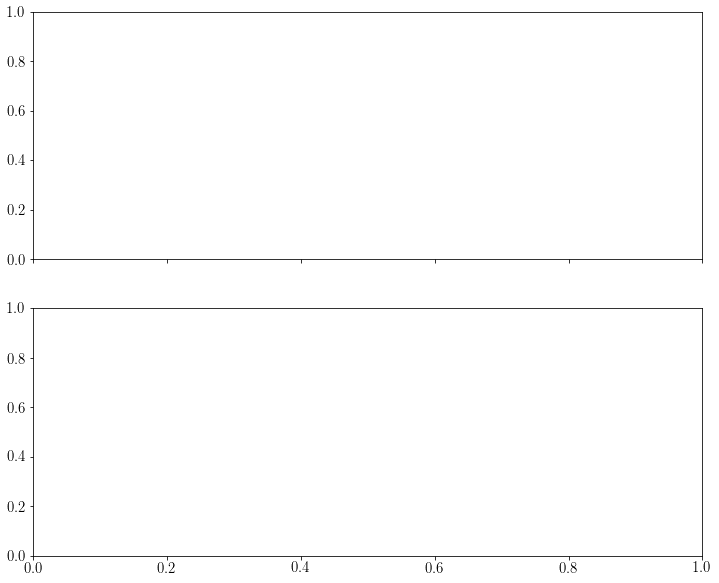

In [7]:
lit_pcba_enrich_f, lit_pcba_enrich_1_ax, lit_pcba_enrich_10_ax, model_metric_dict = aggregate_results(dataset="lit_pcba")


In [8]:
print([len(x) for x in model_metric_dict.values()])
print([x for x in model_metric_dict.keys()])

[30, 30, 30, 30, 30, 30, 30]
['model', 'enrich-1-mean', 'enrich-1-std', 'enrich-10-mean', 'enrich-10-std', 'train_time', 'test_time']


In [9]:
model_metric_dict

{'model': ['ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'ecfp',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf',
  'rf'],
 'enrich-1-mean': [2.069399965564738,
  2.3795064584538266,
  3.330952380952381,
  0.045232617781637396,
  1.1663285619489998,
  1.6813661022521784,
  1.0862603810454323,
  24.061224489795915,
  2.0753012048192767,
  10.089053254437871,
  0.0,
  4.080977345066467,
  0.0,
  21.240000000000002,
  0.0,
  54.42164509037616,
  12.98880794701987,
  0.0,
  15.980676283943328,
  46.18250275505177,
  2.4976023017902813,
  33.25650887573964,
  61.48979591836735,
  39.43648450090056,
  16.94299687654118,
  33.31358024691358,
  24.28181520314548,
  29.469277108433733,
  59.24971081550029,
  41.514545454545456],
 'enrich-1-std': [0.9398219312808189,
  4.440892098500626e-16,
  9.992857142857142,
  0.1356978533449122,
  0.483

In [10]:
# 'smiles-pe.ngram.2', 'smiles-pe.ngram.3', 'rf', 'mlp'

In [11]:
# import pdb 
# pdb.set_trace()

model_metric_df = pd.DataFrame(model_metric_dict)
# model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
#                                       "enrich-1": [tup[1] for tup in model_metric_df[col].values],
#                                       "enrich-10": [tup[2] for tup in model_metric_df[col].values],
#                                       "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

# model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time
0,ecfp,2.069400,9.398219e-01,1.566705,4.233523e-01,12.310308,0.013123
1,ecfp,2.379506,4.440892e-16,1.428475,0.000000e+00,22.846214,0.031297
2,ecfp,3.330952,9.992857e+00,3.330952,4.440892e-16,0.436132,0.001166
3,ecfp,0.045233,1.356979e-01,0.407231,4.524785e-02,25.965528,0.036600
4,ecfp,1.166329,4.835343e-01,1.065659,6.689674e-02,17.621573,0.025980
5,ecfp,1.681366,2.317242e+00,1.350220,8.091162e-01,5.617586,0.002949
6,ecfp,1.086260,0.000000e+00,1.738994,0.000000e+00,26.196881,0.036289
7,ecfp,24.061224,8.020408e+00,5.142857,1.142857e+00,0.395277,0.002089
8,ecfp,2.075301,2.784309e+00,1.457981,1.152164e+00,2.280955,0.002743
9,ecfp,10.089053,3.363018e+00,2.600969,3.747675e-01,0.397921,0.001986


# VINA result

In [12]:
from pathlib import Path
def docking_main(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")

#     color_dict.update({"Vina": "salmon"})

    path_list = [path for path in root_p.glob("*-actives.csv")]


    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
#         '''
        target = path.name.split(".")[0].split("-")[0]
        print(target, idx+1, path)
        
        

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv")
        
        if not merged_df_path.exists():
            # can use the set of smiles in each result file
            result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        




            target_train_smiles_list = []
            target_test_smiles_list = []

            with open(result_pkl, "rb") as handle:

                data = pickle.load(handle)

                target_train_smiles_list = data["smiles_train"]
                target_test_smiles_list = data["smiles_test"]

                print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

            df_cols = ['file', ' scores/1', ' ligName']
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv"), sep=",", usecols=df_cols, nrows=nrows)
            active_df['y_true'] = [1] * len(active_df)



            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            # this will search over all of the docking results for each target, across each of the multiple protein models




            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
        else:
            merged_df = pd.read_csv(merged_df_path)
            
            if 'target' not in merged_df.columns:
                merged_df['target'] = [target] * len(merged_df)
                merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
    return df
    
    
    
#######
vina_result = docking_main(nrows=None)
vina_result
###########



vina_enrich_1_list = []
vina_enrich_10_list = []

vina_col=' scores/1'
for target, target_df in vina_result.groupby("target"):
    
    ef_1 = compute_enrichment_factor(sample_scores=np.abs(target_df[vina_col]), sample_labels=target_df["y_true"], n_percent=0.01)
    ef_10 = compute_enrichment_factor(sample_scores=np.abs(target_df[vina_col]), sample_labels=target_df["y_true"], n_percent=0.1)

        
    vina_enrich_1_list.append(ef_1)
    vina_enrich_10_list.append(ef_10)
    
    
    print(f"{target}, {ef_1:.4f}\t{ef_10:.4f}\t{target_df.shape[0]}")
    

##################
model_metric_df = pd.concat([model_metric_df, pd.DataFrame({"metric": [0]*15, "enrich-1-mean": vina_enrich_1_list, 
                                            "enrich-10-mean": vina_enrich_10_list,
                                          "model": ["Vina"]*15, 
                                                           })])

model_metric_df




  0%|          | 0/15 [00:00<?, ?it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
PKM2 1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv


  7%|▋         | 1/15 [00:00<00:11,  1.19it/s]

1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv
GBA 2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


 27%|██▋       | 4/15 [00:01<00:03,  2.78it/s]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
ESR1_ago 3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
MAPK1 4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv
VDR 5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


 33%|███▎      | 5/15 [00:02<00:03,  2.50it/s]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv
KAT2A 6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


 40%|████      | 6/15 [00:03<00:04,  1.97it/s]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
ALDH1 7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv


 60%|██████    | 9/15 [00:03<00:01,  3.53it/s]

7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
TP53 8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
PPARG 9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv
ADRB2 10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


 67%|██████▋   | 10/15 [00:04<00:01,  2.71it/s]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
MTORC1 11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
OPRK1 12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv


 80%|████████  | 12/15 [00:04<00:00,  3.08it/s]

12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv
IDH1 13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


 87%|████████▋ | 13/15 [00:05<00:00,  2.72it/s]

13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
ESR1_ant 14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv
FEN1 15 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


100%|██████████| 15/15 [00:06<00:00,  2.45it/s]


0 3 78337 784 0.0
0 3 78337 7834 0.0
ADRB2, 0.0000	0.0000	78337
23 1807 37407 375 1.2696712783619257
288 1807 37407 3741 1.593674070674988
ALDH1, 1.2697	1.5937	37407
0 4 1894 19 0.0
1 4 1894 190 2.4921052631578946
ESR1_ago, 0.0000	2.4921	1894
3 38 1736 18 7.614035087719298
5 38 1736 174 1.3127646702964308
ESR1_ant, 7.6140	1.3128	1736
1 101 90555 906 0.9896072388695824
21 101 90555 9056 2.0790931235349683
FEN1, 0.9896	2.0791	90555
2 46 76176 762 4.346456692913385
13 46 76176 7618 2.825938566552901
GBA, 4.3465	2.8259	76176
0 10 91666 917 0.0
2 10 91666 9167 1.9999127304461657
IDH1, 0.0000	1.9999	91666
0 51 89380 894 0.0
4 51 89380 8938 0.7843137254901961
KAT2A, 0.0000	0.7843	89380
1 80 16150 162 1.246141975308642
19 80 16150 1615 2.375
MAPK1, 1.2461	2.3750	16150
0 24 8267 83 0.0
2 24 8267 827 0.833031035872632
MTORC1, 0.0000	0.8330	8267
0 5 67548 676 0.0
1 5 67548 6755 1.9999407846039974
OPRK1, 0.0000	1.9999	67548
3 137 61777 618 2.188966054850826
25 137 61777 6178 1.8247289061964636
PKM

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,metric
0,ecfp,2.069400,9.398219e-01,1.566705,4.233523e-01,12.310308,0.013123,NaN
1,ecfp,2.379506,4.440892e-16,1.428475,0.000000e+00,22.846214,0.031297,NaN
2,ecfp,3.330952,9.992857e+00,3.330952,4.440892e-16,0.436132,0.001166,NaN
3,ecfp,0.045233,1.356979e-01,0.407231,4.524785e-02,25.965528,0.036600,NaN
4,ecfp,1.166329,4.835343e-01,1.065659,6.689674e-02,17.621573,0.025980,NaN
5,ecfp,1.681366,2.317242e+00,1.350220,8.091162e-01,5.617586,0.002949,NaN
6,ecfp,1.086260,0.000000e+00,1.738994,0.000000e+00,26.196881,0.036289,NaN
7,ecfp,24.061224,8.020408e+00,5.142857,1.142857e+00,0.395277,0.002089,NaN
8,ecfp,2.075301,2.784309e+00,1.457981,1.152164e+00,2.280955,0.002743,NaN
9,ecfp,10.089053,3.363018e+00,2.600969,3.747675e-01,0.397921,0.001986,NaN


In [13]:
model_metric_df

model_enrich_10_df = model_metric_df[["model", "enrich-10-mean"]]
model_enrich_10_df = model_enrich_10_df.rename(columns={"enrich-10-mean": "enrich"})
model_enrich_1_df = model_metric_df[["model", "enrich-1-mean"]]
model_enrich_1_df = model_enrich_1_df.rename(columns={"enrich-1-mean": "enrich"})


In [14]:
model_enrich_10_df.columns

Index(['model', 'enrich'], dtype='object')

In [15]:
model_enrich_1_df

,model,enrich
0,ecfp,2.069400
1,ecfp,2.379506
2,ecfp,3.330952
3,ecfp,0.045233
4,ecfp,1.166329
5,ecfp,1.681366
6,ecfp,1.086260
7,ecfp,24.061224
8,ecfp,2.075301
9,ecfp,10.089053


In [16]:
def make_plot(enrich_1_df, enrich_10_df, multistep_path, p_1, p_10, combo_model_name):
    multistep_df = pd.read_csv(multistep_path,
                          index_col=0)
    multistep_df["model"] = ["HDC-MLP"] * len(multistep_df)
    multistep_df = multistep_df[["model", "enrich", "p"]]
    
    multistep_1_df = multistep_df[multistep_df["p"] == p_1]
    multistep_1_df = multistep_1_df[["model", "enrich"]]
    
    multistep_10_df = multistep_df[multistep_df["p"] == p_10]
    multistep_10_df = multistep_10_df[["model", "enrich"]]
    
    
    enrich_1_df = pd.concat([enrich_1_df, multistep_1_df])
    enrich_10_df = pd.concat([enrich_10_df, multistep_10_df])
    
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.boxplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
    sns.boxplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
    labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
    labels[-1] = combo_model_name
    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[0].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
#     enrich_f.savefig("enrich.png", dpi=600, bbox_inches="tight")

#     return enrich_f

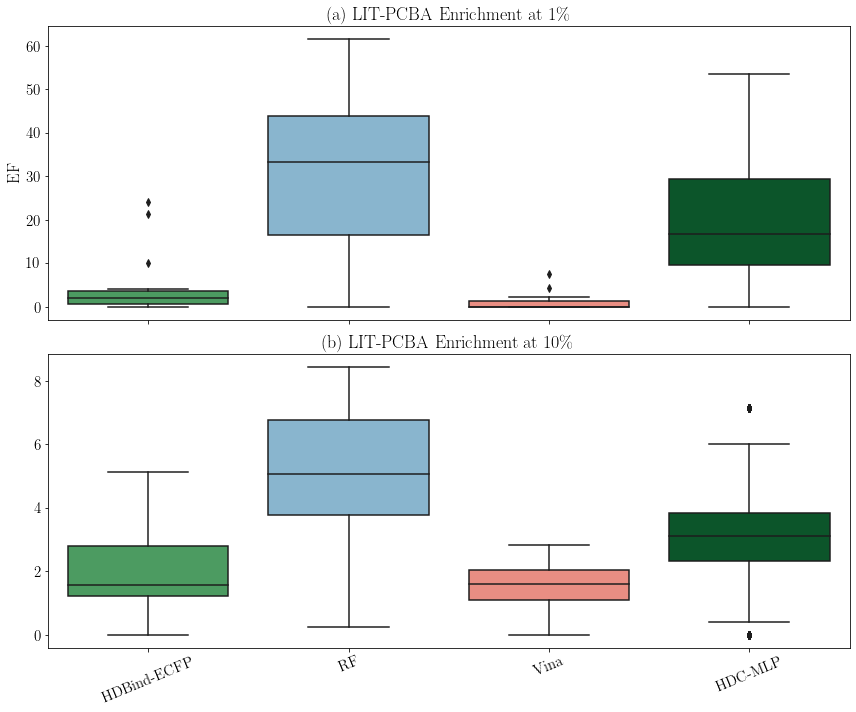

In [17]:
make_plot(enrich_1_df=model_enrich_1_df, enrich_10_df=model_enrich_10_df, 
         multistep_path="/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/125_lit-pcba_0.5_multistep_enrich.csv",
         p_1=.02, p_10=.2,
         combo_model_name="HDC-MLP")

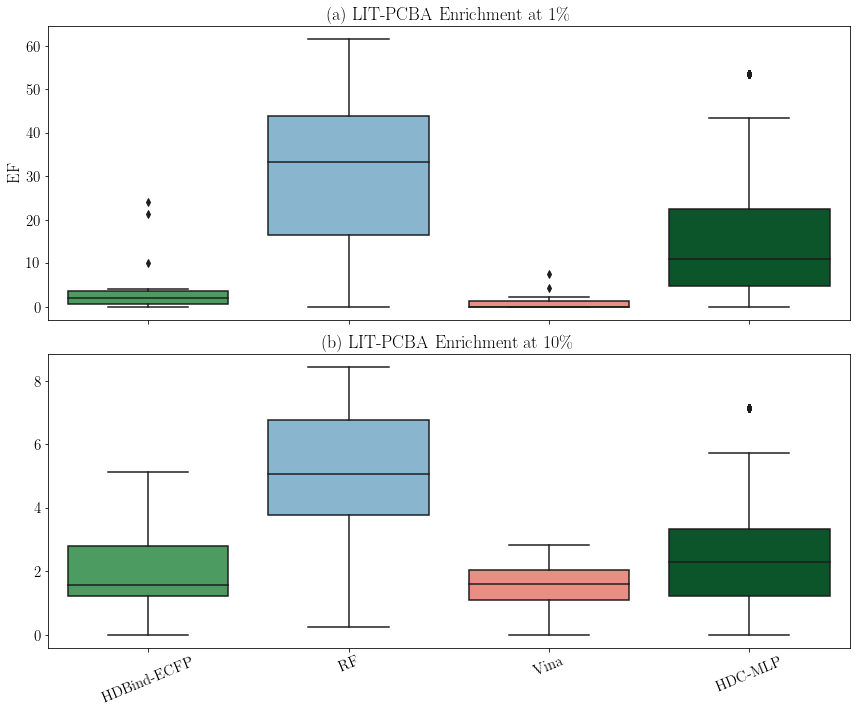

In [18]:
make_plot(enrich_1_df=model_enrich_1_df, enrich_10_df=model_enrich_10_df, 
         multistep_path="/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/125_lit-pcba_0.2_multistep_enrich.csv",
         p_1=.05, p_10=.5, combo_model_name="HDC-MLP")

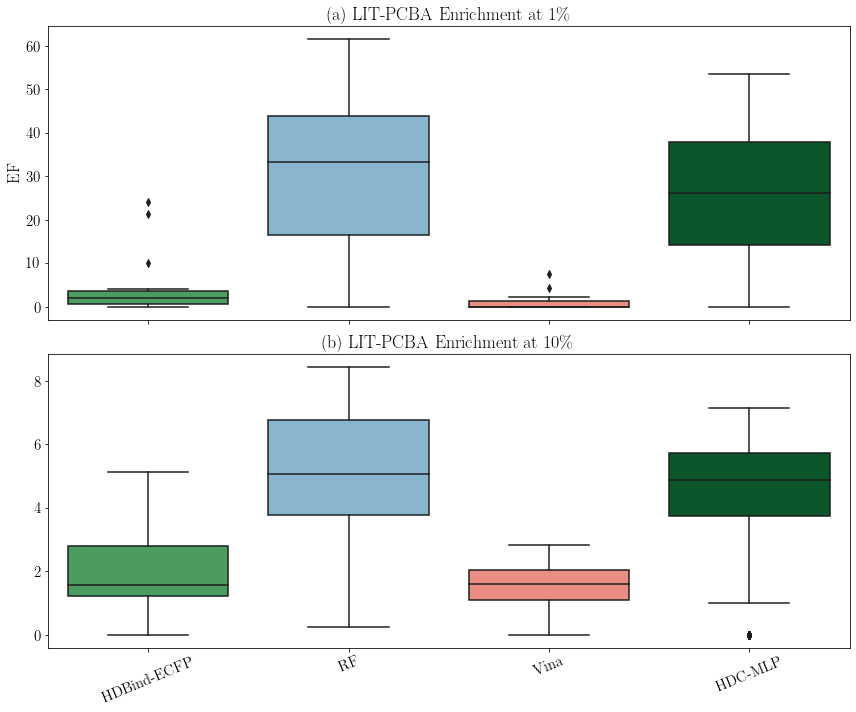

In [19]:
make_plot(enrich_1_df=model_enrich_1_df, enrich_10_df=model_enrich_10_df, 
         multistep_path="/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/125_lit-pcba_1.0_multistep_enrich.csv",
         p_1=.01, p_10=.1, combo_model_name="HDC-MLP")

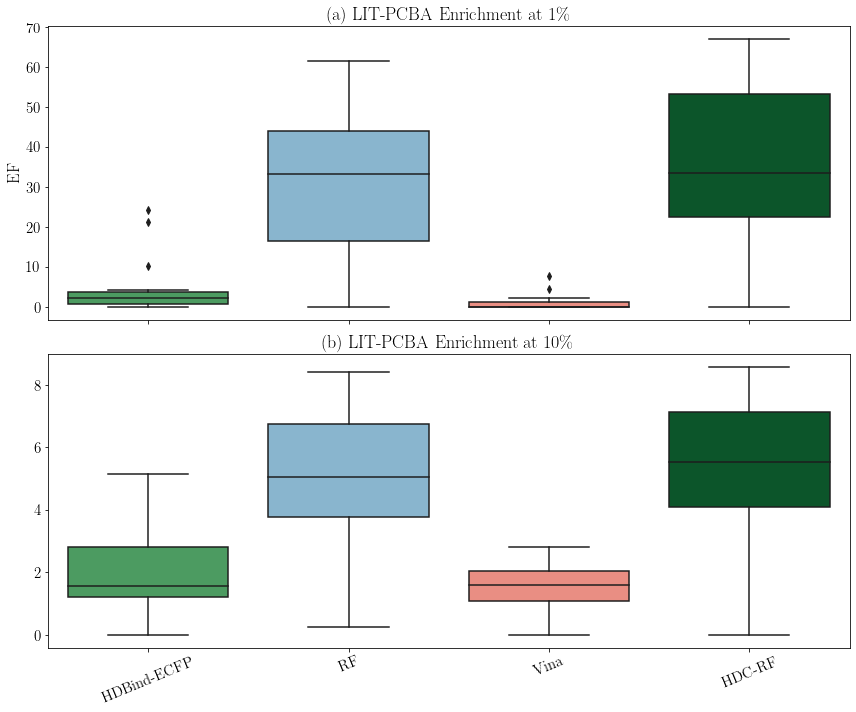

In [20]:
make_plot(enrich_1_df=model_enrich_1_df, enrich_10_df=model_enrich_10_df, 
         multistep_path="/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/125_lit-pcba_rf_1.0_multistep_enrich.csv",
         p_1=.01, p_10=.1, combo_model_name="HDC-RF")

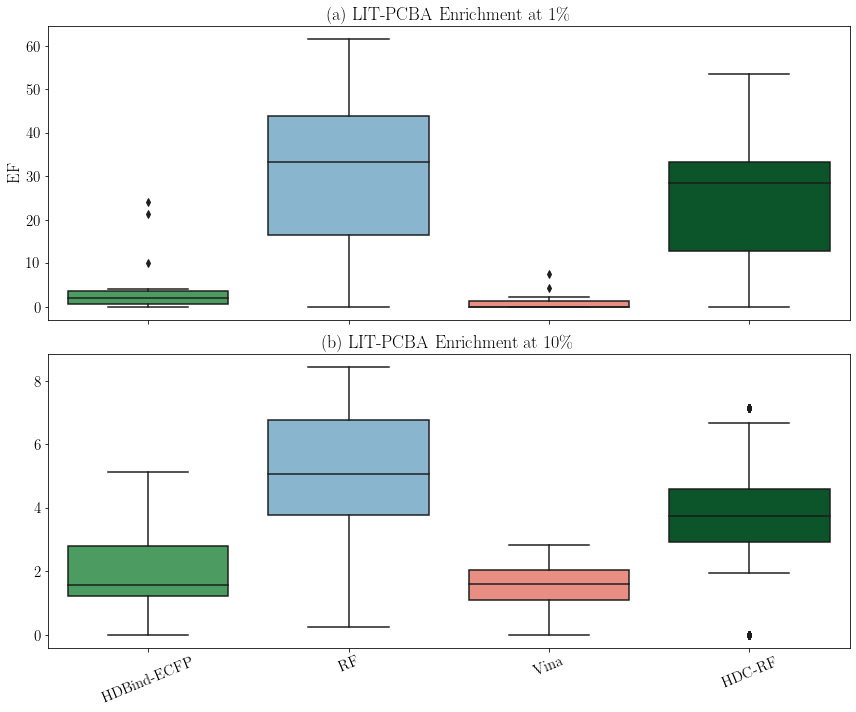

In [21]:
make_plot(enrich_1_df=model_enrich_1_df, enrich_10_df=model_enrich_10_df, 
         multistep_path="/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/125_lit-pcba_rf_0.5_multistep_enrich.csv",
         p_1=.02, p_10=.2, combo_model_name="HDC-RF")

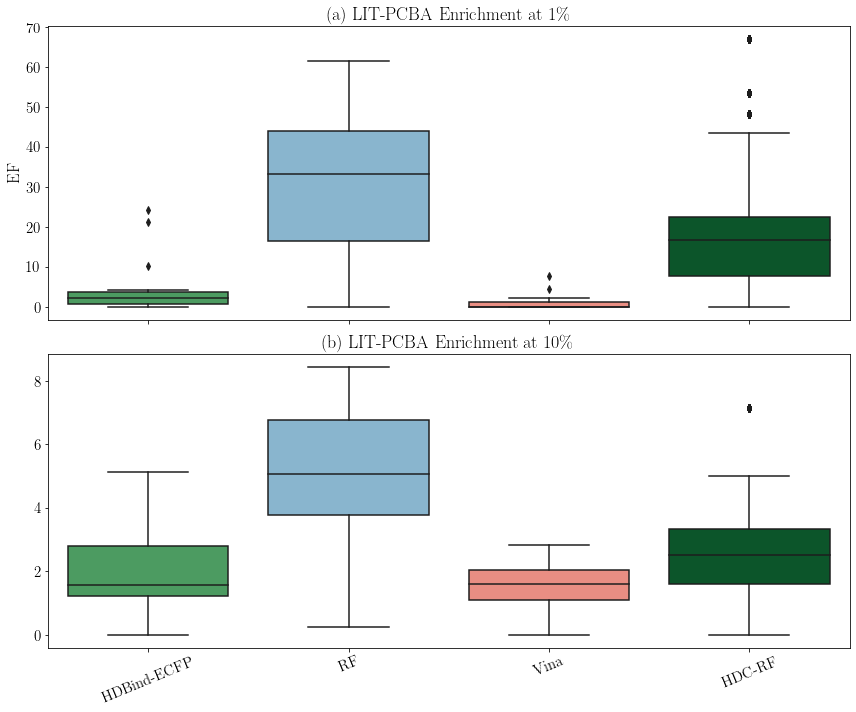

In [22]:
make_plot(enrich_1_df=model_enrich_1_df, enrich_10_df=model_enrich_10_df, 
         multistep_path="/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/125_lit-pcba_rf_0.2_multistep_enrich.csv",
         p_1=.05, p_10=.5, combo_model_name="HDC-RF")

# TIMINGS

In [23]:
model_metric_df.groupby("model").describe()[['enrich-1-mean', 'enrich-10-mean']]

enrich-1-mean                                                   \
              count       mean        std  min        25%        50%   
model                                                                  
Vina           15.0   1.264663   2.130390  0.0   0.000000   0.000000   
ecfp           15.0   4.887040   7.657825  0.0   0.565746   2.069400   
rf             15.0  31.408972  19.401708  0.0  16.461837  33.256509   

                            enrich-10-mean                                \
             75%        max          count      mean       std       min   
model                                                                      
Vina    1.292371   7.614035           15.0  1.591800  0.752791  0.000000   
ecfp    3.705965  24.061224           15.0  2.010702  1.541751  0.000000   
rf     43.848524  61.489796           15.0  4.966419  2.240883  0.249984   

                                               
            25%       50%       75%       max  
model                                          
Vina   1.081557  1.593674  2.039517  2.825939  
ecfp   1.207940  1.566705  2.800352  5.142857  
rf     3.780519  5.048940  6.763992  8.428571

In [24]:
group_dict = {group_name: group_df for group_name, group_df in model_metric_df.groupby('model')}

In [25]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['train_time'].mean()}")

Vina-nan
ecfp-14.304530384063721
rf-2.5236550159454345


In [26]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['test_time'].mean()}")

Vina-nan
ecfp-0.019370131492614743
rf-0.24203364372253422


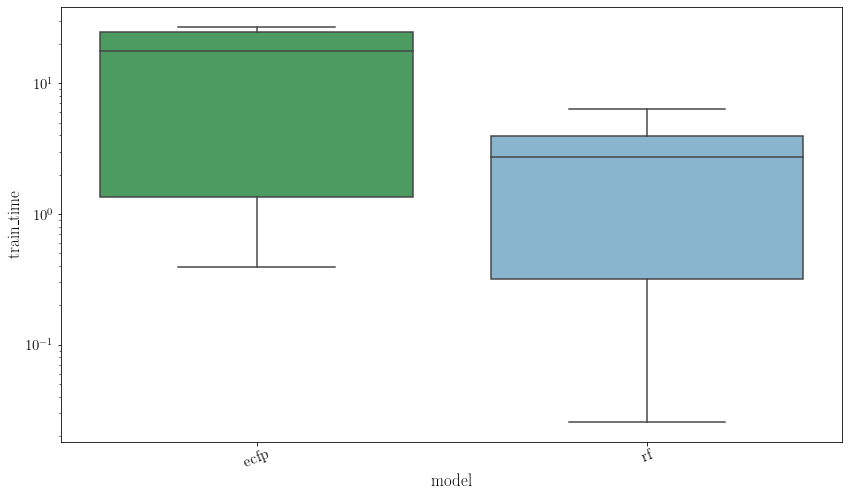

In [27]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="train_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

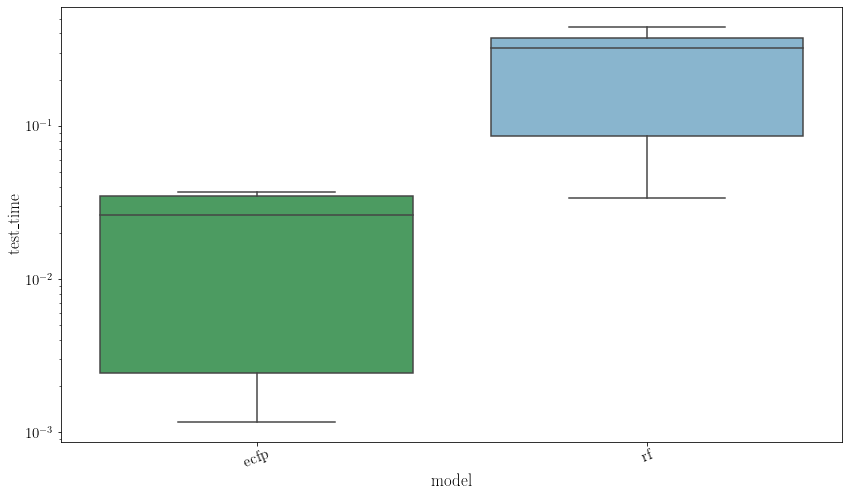

In [28]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="test_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")